In [1]:
%load_ext autoreload
%autoreload 2

from wavesolve.waveguide import FiberBundleLantern
from wavesolve.fe_solver import get_eff_index, plot_vector_mode, plot_scalar_mode, solve_waveguide_vec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wavesolve.utils import create_distinct_colormap, plot_modes
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

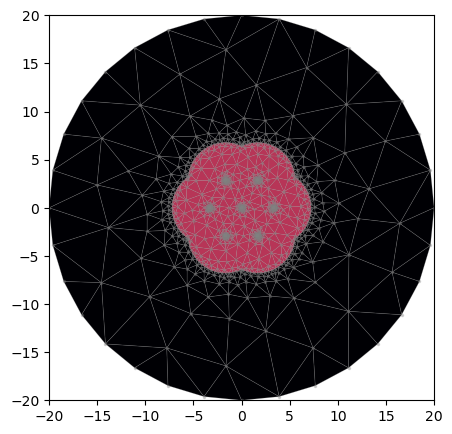

In [17]:
target_radius=5
Bnd_PL = FiberBundleLantern(r_jack=750, r_fiber_clad=125/2, r_core=10.2/2, n_rings=1,
                            n_core=1.4521, n_clad=1.44692, n_jack=1.44692-5.e-3,
                            core_res=16, clad_res=64, jack_res=32,
                            r_target_mmcore_size=target_radius,
                            ring_clad_factors={0: 3, 1: 2.33, 2: 1})

m = Bnd_PL.make_mesh(order=1,adaptive=True)

Bnd_PL.plot_mesh(m)

In [19]:
wl = 1.55
w,v,n_modes = solve_waveguide_vec(m,wl,Bnd_PL.assign_IOR(),plot=False,Nmax=100,sparse_solve_mode="pardiso")

print(f"{n_modes} vector modes were found.")

building matrices ... 
solving...
solving complete
6 vector modes were found.


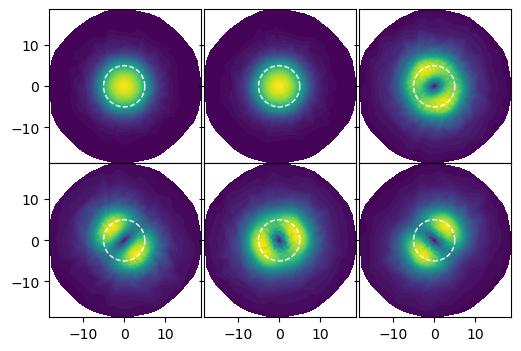

In [21]:
from wavesolve.utils import create_distinct_colormap, plot_modes
IOR_dict=Bnd_PL.assign_IOR()
plot_modes(w, v, m, wl, IOR_dict, target_radius=target_radius,
               basefigsize=2, no_cols=3, circle_color='white',
               circle_linewidth=1, circle_linestyle='dashed')

In [22]:
lambdaStart = 1.0
lambdaEnd = 1.8

rStart = 2
rEnd = 8

resolution=20

wavelengths = np.linspace(lambdaStart, lambdaEnd, resolution)
radiuses = np.linspace(rStart, rEnd, resolution)

tileX = 0
tileY = 0
tiles = np.zeros((resolution, resolution))

# analysis procedure: 1. create mesh for each radius. 2. solve wavesolver for each wavelength. 3. capture N number of modes in tiles array
for mm_core_radius in tqdm(radiuses):
    Bnd_PL = FiberBundleLantern(r_jack=750, r_fiber_clad=125/2, r_core=10.2/2, n_rings=1,
                                n_core=1.4521, n_clad=1.44692, n_jack=1.44692-5.e-3,
                                core_res=16, clad_res=64, jack_res=32,
                                r_target_mmcore_size=mm_core_radius,
                                ring_clad_factors={0: 3, 1: 2.33, 2: 1})

    m = Bnd_PL.make_mesh(order=1,adaptive=True)
    IOR_dict = Bnd_PL.assign_IOR()

    for wavelength in tqdm(wavelengths):
        # w_PL,v_PL,N_PL = solve_waveguide(PL, wavelength, IOR_dict_lant, plot = False, sparse = True)
        w_PL,v_PL,N_PL = solve_waveguide_vec(m,wavelength,IOR_dict,plot=False,Nmax=80,sparse_solve_mode="pardiso", verbose=False)
        tiles[tileX, tileY] = N_PL
        tileY += 1
    tileY = 0
    tileX += 1

100%|██████████| 20/20 [37:08<00:00, 111.41s/it]


Text(1.62, 4.5, 'H')

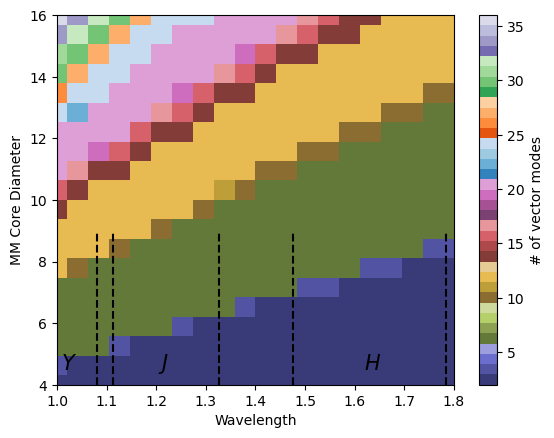

In [29]:
fig, ax = plt.subplots()
plt.xlabel("Wavelength")
plt.ylabel("MM Core Diameter")
im = ax.pcolormesh(wavelengths,2*radiuses, tiles, cmap=create_distinct_colormap(int(np.max(tiles))))
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('# of vector modes')

ax.set_xlim(1, 1.8)
ax.set_ylim(np.min(2*radiuses), np.max(2*radiuses))

labelypos=[np.min(2*radiuses),np.min(2*radiuses)+5]
#Y
plt.plot([1.02-.12/2, 1.02-.12/2],labelypos, color = 'black', linestyle = 'dashed')
plt.plot([1.02+.12/2, 1.02+.12/2],labelypos, color = 'black', linestyle = 'dashed')
plt.text(1.01,labelypos[0]+0.5,"Y", color = 'black', size = 15, fontstyle = 'italic', )
#J
plt.plot([1.22-.213/2, 1.22-.213/2],labelypos, color = 'black', linestyle = 'dashed')
plt.plot([1.22+.213/2, 1.22+.213/2],labelypos, color = 'black', linestyle = 'dashed')
plt.text(1.21,labelypos[0]+0.5,"J", color = 'black', size = 15, fontstyle = 'italic', )
#H
plt.plot([1.63-.307/2, 1.63-.307/2],labelypos, color = 'black', linestyle = 'dashed')
plt.plot([1.63+.307/2, 1.63+.307/2],labelypos, color = 'black', linestyle = 'dashed')
plt.text(1.62,labelypos[0]+0.5,"H", color = 'black', size = 15, fontstyle = 'italic', )


36